In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

colors_ = ["blue", "red", "green", "gray", "black"]

import pylib.mix as mix
import pylib.measurement as mse

23852
/media/work/docs/codes/QuCF/scripts-py


In [7]:
for i in range(30):
    plt.close()

path_qucf_ = "../QuCF/simulations/MI/sin"
name_qucf_pr_   = "MI"
name_qucf_file_ = name_qucf_pr_ + "_OUTPUT.hdf5"
path_save_plots_ = "./tools/QSVT-angles/inversion/saved-plots/"

   nx 	7
   alpha_k0 	-1.570796326795e+00
   alpha_k1 	1.583164801809e+00


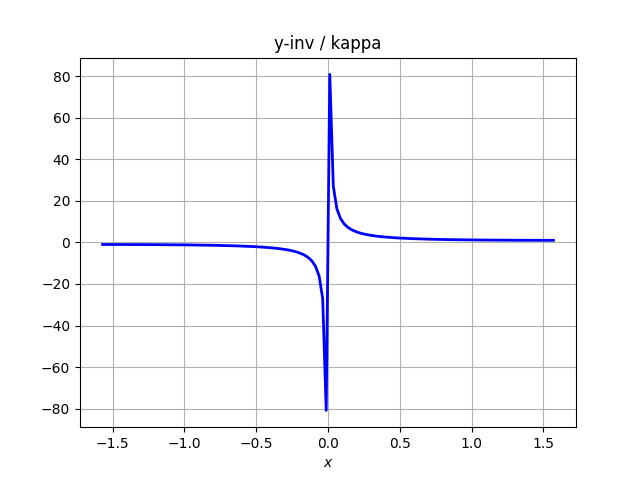

In [17]:
# ------------------------------------------------------------------
# --- Create a reference matrix ---
# ------------------------------------------------------------------
def prepare_ref():
    # --- Original matrix ---
    
    # --- x grid ---
    Nx_ = 1 << nx_
    xmax = np.pi/2.
    x_ = np.linspace(-xmax, xmax, Nx_)

    # --- matrix whose singular values encode the function ---
    y = np.sin(x_)
    A_ = np.diag(y)

    # --- reference inverse function ---
    y_inv_ref_ = 1. / y

    # --- SIN parameters ---
    alpha_k0 = - xmax
    alpha_k1 = np.abs(alpha_k0) * Nx_ /(Nx_  - 1)
    print("   nx \t{:d}".format(nx_))
    print("   alpha_k0 \t{:0.12e}".format(alpha_k0))
    print("   alpha_k1 \t{:0.12e}".format(alpha_k1))

    # --- Plotting the initial function ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_, y_inv_ref_, color='b', linewidth = 2, linestyle='-')
    plt.xlabel('$x$')
    plt.title("y-inv / kappa")
    plt.grid(True)
    plt.show()

    return x_, Nx_, A_, y_inv_ref_
# --------------------------------------------------------------
nx_ = 7
x_, Nx_, A_, y_inv_ref_ = prepare_ref()

In [18]:
# ----------------------------------------------------------
# --- Compute the condition number ---
# ----------------------------------------------------------
from numpy import linalg as LA
def compute_kappa():
    evals, evecs = LA.eig(A_)
    kappa = np.max(np.abs(evals)) / np.min(np.abs(evals))
    print("nx: \t{:d}".format(nx_))
    print("cond. number: {:0.1f}".format(kappa))
    return
# ----------------------------------------------------------------
compute_kappa()


nx: 	7
cond. number: 80.9


Reading the file ../QuCF/simulations/MI/sin/results//MI_nx7_k5e2_OUTPUT.hdf5...
Name of the simulation is MI
Simulation has been performed  07-27-2024 21:40:05

QSVT kappa: 5.0e+02

max. relative err: 1.236e-03


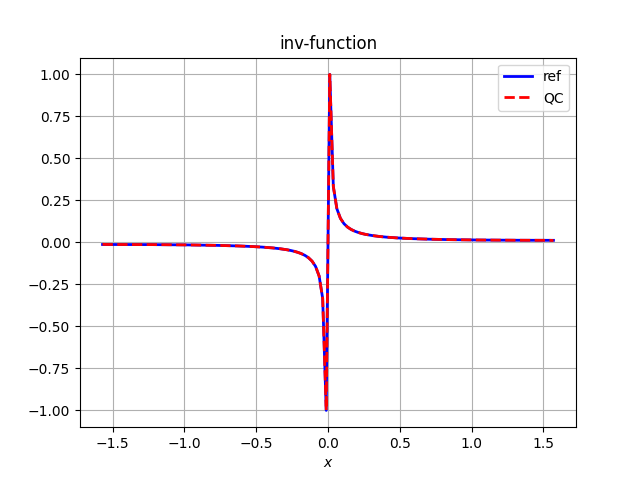

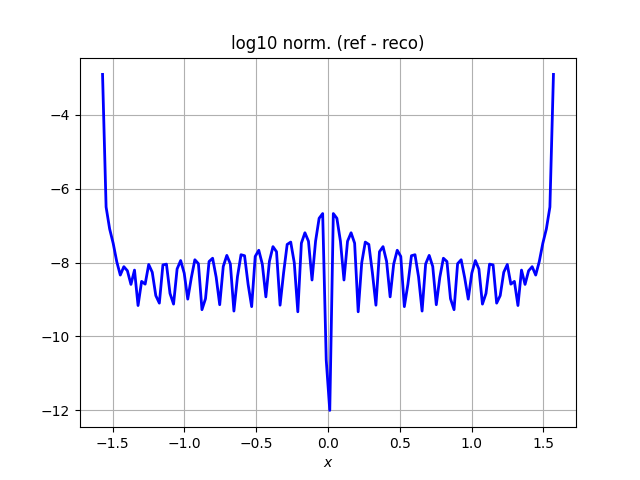

In [19]:
# -------------------------------------------------
# --- Compare with QuCF simulations ---
# -------------------------------------------------
mix.reload_module(mse)
def compare_with_qucf(kappa, flag_adv, flag_save):
    # --- Reading QC data ---
    km, ke = mix.get_order_base10(kappa)
    str_k = "{:0.0f}e{:d}".format(km, ke)
    pr_name = "MI_nx{:d}_k{:s}".format(nx_, str_k)
    if flag_adv:
        pr_name += "_ADV"
        
    # pr_name = name_qucf_pr_

    om = mse.MeasOracle__(True)
    om.path_  = path_qucf_ + "/results/"
    om.pname_ = pr_name
    om.open()

    # --- QSVT parameter ---
    om.read_qsvt()
    kappa_qc = om.dd_["qsvt_mi"]["par"]
    if np.abs(kappa_qc - kappa) > 1e-4:
        print()
        print("<<< ERROR: a wrong QSVT parameter.>>>")
        print()
    print()
    print("QSVT kappa: {:0.1e}".format(kappa_qc))


    # --- Normalize the reference case ---
    y_ref_norm = y_inv_ref_ / kappa

    # --- QuCF data ---
    om.set_zero_ancillae_work_states(0)
    qc_data_all = om.get_var_x({}, "rs")

    y_inv_qc_ = qc_data_all.imag  # correct global phase;

    y_inv_qc_ *= 2**(nx_/2.) / om.dd_["qsvt_mi"]["rescaling_factor"]
    if y_inv_qc_[0] > 0:
        y_inv_qc_ *= -1 # correct global phase;

    # --- Normalize everything to 1 ---
    y_ref_norm /= np.max(np.abs(y_ref_norm))
    y_inv_qc_ /= np.max(np.abs(y_inv_qc_))

    # --- Relative error ---
    norm_diff = y_ref_norm - y_inv_qc_
    max_rel_err = np.max(np.abs(norm_diff))

    log_norm_diff = np.zeros(Nx_)
    for ix in range(Nx_):
        v = np.abs(norm_diff[ix])
        if v < 1e-12:
            v = 1e-12
        log_norm_diff[ix] = np.log10(v)
    print()
    print("max. relative err: {:0.3e}".format(max_rel_err))

    # --- Plotting: comparison ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(
        x_, y_ref_norm, 
        color='b', linewidth = 2, linestyle='-',  
        label = "ref"
    )
    ax.plot(
        x_, y_inv_qc_,
        color='r', linewidth = 2, linestyle='--',  
        label = "QC"
    )
    plt.xlabel('$x$')
    plt.title("inv-function")
    ax.legend()
    plt.grid(True)
    plt.show()

    # --- Plotting: error ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_, log_norm_diff, color='b', linewidth = 2, linestyle='-')
    plt.xlabel('$x$')
    plt.title("log10 norm. (ref - reco)")
    plt.grid(True)
    plt.show()

    if flag_save:
        mix.save_dat_plot_1d_file(
            path_save_plots_ + "/QSVT_sin_ref_k{:s}.dat".format(str_k),
            x_, y_ref_norm
        )
        mix.save_dat_plot_1d_file(
            path_save_plots_ + "/QSVT_sin_reco_k{:s}.dat".format(str_k),
            x_, y_inv_qc_
        )
        mix.save_dat_plot_1d_file(
            path_save_plots_ + "/QSVT_sin_err_x_k{:s}.dat".format(str_k), 
            x_, log_norm_diff
        )
    return
# ----------------------------------------------------------
compare_with_qucf(
    kappa = 5e2,
    flag_adv = False,
    flag_save = False
)

In [ ]:
# --------------------------------------------------------
# --- Scan condition number versus nx ---
# --------------------------------------------------------
def save_scan():
    nx_array = [   10,     11,     12,     13,      14]
    k__array = [860.8, 1722.5, 3445.8, 6892.5, 13785.8]
    mix.save_dat_plot_1d_file(
        path_save_plots_ + "/QSVT_sin_kappa_nx.dat", 
        nx_array, k__array
    )
    return
# ------------------------------------------------------------------------------
def save_max_rel_error():
    # k-qsvt:   861,             2000,       4000,      7000,      14000
    nx_array  = [       10,        11,         12,        13,        14]
    err_array = [5.379e-06, 1.412e-05,  2.123e-05, 3.401e-05, 5.159e-05]
    mix.save_dat_plot_1d_file(
        path_save_plots_ + "/QSVT_sin_err_nx.dat", 
        nx_array, np.log10(err_array)
    )
    return
# ------------------------------------------------------------------------------
save_scan()
save_max_rel_error()